In [1]:
#importing libraries
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import PIL
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
import glob

In [2]:
#installing and importing Augmentor library
!pip install Augmentor
import Augmentor

In [3]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


Creating dataset for training as well as validation using tf.keras.image_dataset_from_directory.

In [6]:
dataset_dir = '/content/gdrive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration'
train_dir = os.path.join(dataset_dir, 'Train')
test_dir = os.path.join(dataset_dir, 'Test')

# Define image size and batch size
img_height = 180
img_width = 180
batch_size = 32

# Load the training dataset
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    train_dir,
    validation_split=0.2,
    subset='training',
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size,
    label_mode='categorical'
)

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    train_dir,
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size,
    label_mode='categorical'
)

test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    test_dir,
    image_size=(img_height, img_width),
    batch_size=batch_size,
    label_mode='categorical'
)

Found 2239 files belonging to 9 classes.
Using 1792 files for training.
Found 2239 files belonging to 9 classes.
Using 447 files for validation.
Found 118 files belonging to 9 classes.


In [7]:
#to find out the class names and store them in a list
class_names = train_ds.class_names
print("Class names:", class_names)

Class names: ['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


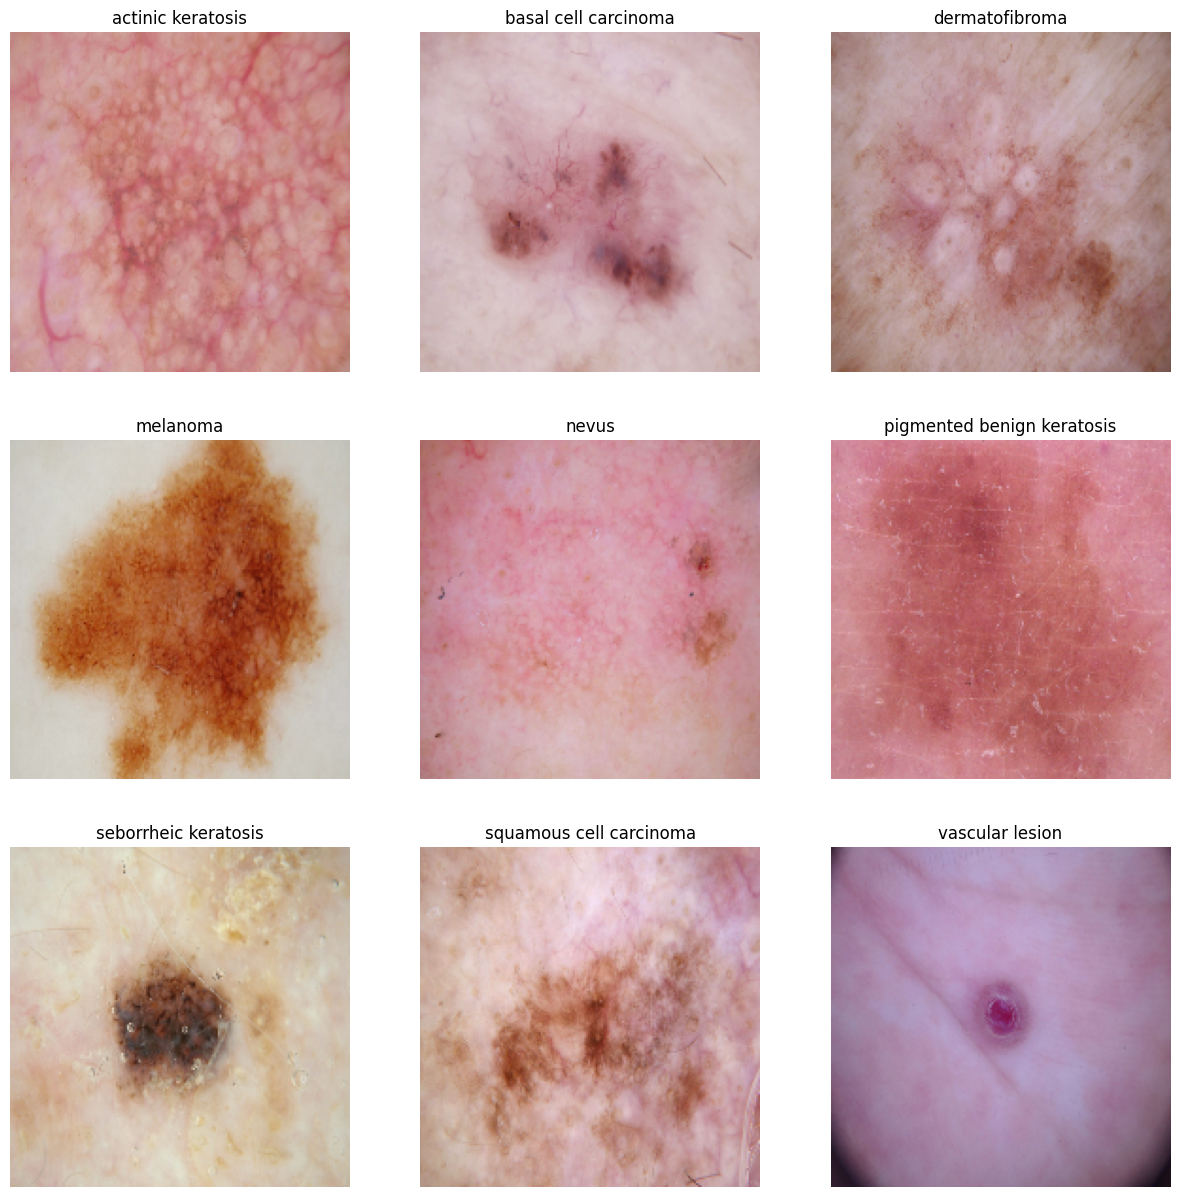

In [8]:
# Initializing a dictionary to store one instance of each class
instances = {class_name: None for class_name in class_names}

# for collecting one instance for each class
for images, labels in train_ds:
    for i in range(len(labels)):
        class_idx = tf.argmax(labels[i]).numpy()
        class_name = class_names[class_idx]
        if instances[class_name] is None:
            instances[class_name] = images[i]
    # Break the loop if all classes have been collected
    if all(value is not None for value in instances.values()):
        break

# Plot one instance of each class
plt.figure(figsize=(15, 15))
for i, class_name in enumerate(class_names):
    plt.subplot(3, 3, i + 1)
    plt.title(class_name)
    plt.axis('off')
    plt.imshow(instances[class_name].numpy().astype("uint8"))

plt.show()

Creating model by using Sequential from tensorflow.

In [9]:
model = Sequential([
  tf.keras.layers.Rescaling(1./255,input_shape=(img_height, img_width,3)),
  tf.keras.layers.Conv2D(64, (3, 3), padding='same', activation='relu'),
  tf.keras.layers.BatchNormalization(),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(128, (3, 3), padding='same', activation='relu'),
  tf.keras.layers.BatchNormalization(),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(256, (3, 3), padding='same', activation='relu'),
  tf.keras.layers.BatchNormalization(),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(512, activation='relu'),
  tf.keras.layers.Dense(len(class_names),activation='softmax')
])

/usr/local/lib/python3.10/dist-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [10]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ rescaling (Rescaling)                │ (None, 180, 180, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 180, 180, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 180, 180, 64)        │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 90, 90, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 90, 90, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 90, 90, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 45, 45, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 45, 45, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 45, 45, 256)         │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 22, 22, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 123904)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 512)                 │      63,439,360 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 9)                   │           4,617 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 63,816,585 (243.44 MB)

 Trainable params: 63,815,689 (243.44 MB)

 Non-trainable params: 896 (3.50 KB)

In [11]:
#compiling the model
model.compile(optimizer='adam',loss='CategoricalCrossentropy',metrics=[keras.metrics.AUC(),'accuracy'])

In [12]:
#fitting the model
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 356s 6s/step - accuracy: 0.2660 - auc: 0.6256 - loss: 40.9599 - val_accuracy: 0.0828 - val_auc: 0.4988 - val_loss: 41.9136
Epoch 2/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 21s 378ms/step - accuracy: 0.3007 - auc: 0.7397 - loss: 1.9063 - val_accuracy: 0.1544 - val_auc: 0.5233 - val_loss: 40.9902
Epoch 3/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 19s 333ms/step - accuracy: 0.3379 - auc: 0.7727 - loss: 1.8498 - val_accuracy: 0.1611 - val_auc: 0.5408 - val_loss: 32.7940
Epoch 4/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 21s 370ms/step - accuracy: 0.4394 - auc: 0.8138 - loss: 1.6268 - val_accuracy: 0.2103 - val_auc: 0.5649 - val_loss: 25.3542
Epoch 5/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 19s 337ms/step - accuracy: 0.4327 - auc: 0.8364 - loss: 1.5525 - val_accuracy: 0.2349 - val_auc: 0.5726 - val_loss: 19.1423
Epoch 6/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 21s 370ms/step - accuracy: 0.4522 - auc: 0.8501 - loss: 1.4909 - val_accuracy: 0.1655 - val_auc: 0.5646 - val_loss: 13.1285
Epoch 7/20
56/56 ━━━━━━━━━━━━

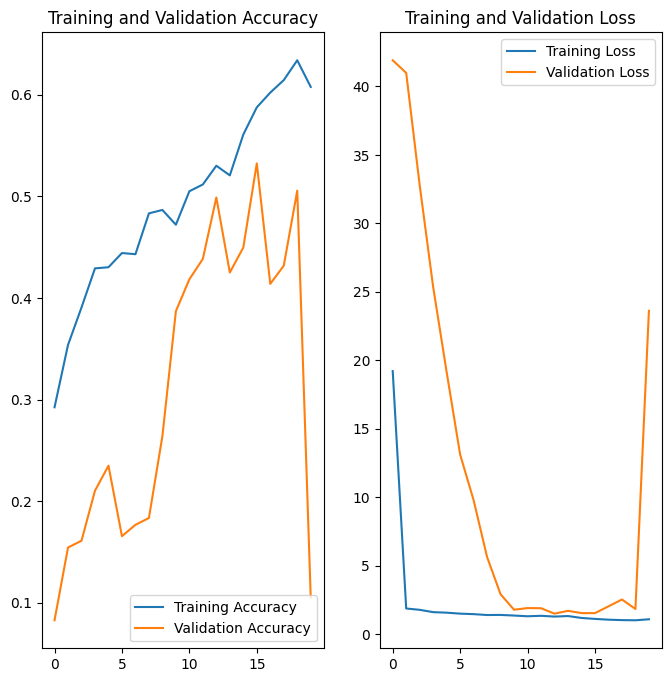

In [13]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

It can be observed that even though the training accuracy is very high but the validation accuracy is low and thus the model is overfitting. This is majorly due to the class imbalance.

In [14]:
import numpy as np
from collections import Counter

def count_class_distribution(dataset):
    class_counts = Counter()
    for images, labels in dataset:
        labels_list = np.argmax(labels.numpy(), axis=1)  # Convert one-hot encoded labels to class indices
        class_counts.update(labels_list)
    return class_counts

train_class_distribution = count_class_distribution(train_ds)

print("Training dataset class distribution:")
for class_id, count in sorted(train_class_distribution.items()):
    class_name = train_ds.class_names[class_id]
    print(f"Class '{class_name}': {count} images")

Training dataset class distribution:
Class 'actinic keratosis': 92 images
Class 'basal cell carcinoma': 309 images
Class 'dermatofibroma': 77 images
Class 'melanoma': 352 images
Class 'nevus': 277 images
Class 'pigmented benign keratosis': 370 images
Class 'seborrheic keratosis': 58 images
Class 'squamous cell carcinoma': 142 images
Class 'vascular lesion': 115 images


1. Which class has the least number of samples?
**- Dermatofibroma has the least number of samples.**

2. Which classes dominate the data in terms proportionate number of samples?
**- Pigmented benign keratosis has the highest number of samples.**

Initialised with 1 image(s) found.
Output directory set to /content/gdrive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/temp_augmentor_dir/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7CA6DFD53D30>: 100%|██████████| 1/1 [00:00<00:00, 19.76 Samples/s]
Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7CA6DFD50100>: 100%|██████████| 1/1 [00:00<00:00, 19.61 Samples/s]
Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7CA6DFD527D0>: 100%|██████████| 1/1 [00:00<00:00, 19.99 Samples/s]
Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7CA6DFD51390>: 100%|██████████| 1/1 [00:00<00:00, 18.43 Samples/s]


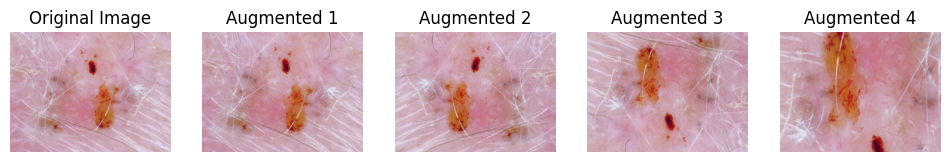

Temporary directory /content/gdrive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/temp_augmentor_dir removed.


In [16]:
import Augmentor
import shutil
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from PIL import Image

# Define paths
original_image_path = '/content/gdrive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/ISIC_0024504.jpg'
temp_dir = '/content/gdrive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/temp_augmentor_dir'
augmented_image_path = '/content/gdrive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/temp_augmentor_dir/output'

# Create a temporary directory
os.makedirs(temp_dir, exist_ok=True)

# Copy the specific image to the temporary directory
shutil.copy(original_image_path, temp_dir)

# Set up the Augmentor pipeline for the temporary directory
p = Augmentor.Pipeline(temp_dir)

# Define some augmentation operations
p.rotate(probability=1.0, max_left_rotation=25, max_right_rotation=25)
p.sample(1)
p.flip_left_right(probability=1.0)
p.sample(1)
p.flip_top_bottom(probability=1.0)
p.sample(1)
p.zoom_random(probability=1.0, percentage_area=0.8)
p.sample(1)

# Find the path of the newly created augmented image
temp_output=os.path.join(temp_dir, os.listdir(temp_dir)[1])
augmented_images = os.listdir(temp_output)

plt.figure(figsize=(12, 6))

# Display the original image
original_img = Image.open(original_image_path)
plt.subplot(1, 5, 1)
plt.imshow(original_img)
plt.title('Original Image')
plt.axis('off')

# Display the augmented images
for i, img_name in enumerate(augmented_images):
    img = Image.open(os.path.join(temp_output, img_name))
    plt.subplot(1, 5, i + 2)
    plt.imshow(img)
    plt.title(f'Augmented {i + 1}')
    plt.axis('off')

plt.show()

# Remove the temporary directory after comparison
shutil.rmtree(temp_dir)
print(f"Temporary directory {temp_dir} removed.")

Using only rotate, flip_left_to_right and flip_top_bottom augmentation as there is a chance that the zoom_random may zoom over the wrong parts of the image and thus may lose out on information.

In [17]:
# Define the paths to your train and test directories
train_dir = '/content/gdrive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train'
test_dir = '/content/gdrive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Test'

# Define the directory where augmented images will be stored
augmented_dir = '/content/gdrive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Augmented_Train'

# Create the augmented images directory if it doesn't exist
os.makedirs(augmented_dir, exist_ok=True)

# Define the number of augmented images you want to generate per class
num_augmented_images = 500  # Adjust this number based on your needs

# Augment data for each class in the training set
for class_name in os.listdir(train_dir):
    class_path = os.path.join(train_dir, class_name)
    if os.path.isdir(class_path):
        print(f"Processing class: {class_name}")

        # Create the corresponding class directory in the augmented directory
        augmented_class_dir = os.path.join(augmented_dir, class_name)
        os.makedirs(augmented_class_dir, exist_ok=True)

        # Set up the Augmentor pipeline for the current class
        p = Augmentor.Pipeline(class_path, output_directory=augmented_class_dir)

        # Define augmentation operations
        p.rotate(probability=0.7, max_left_rotation=25, max_right_rotation=25)
        p.flip_left_right(probability=0.75)
        p.flip_top_bottom(probability=0.75)
        #p.zoom_random(probability=0.75, percentage_area=0.8)

        # Sample augmented images
        p.sample(num_augmented_images)
        print(f"Generated {num_augmented_images} augmented images for class: {class_name}")

Processing class: dermatofibroma
Initialised with 95 image(s) found.
Output directory set to /content/gdrive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Augmented_Train/dermatofibroma.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7CA752F18910>: 100%|██████████| 500/500 [00:21<00:00, 23.03 Samples/s]


Generated 500 augmented images for class: dermatofibroma
Processing class: actinic keratosis
Initialised with 114 image(s) found.
Output directory set to /content/gdrive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Augmented_Train/actinic keratosis.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7CA740747F10>: 100%|██████████| 500/500 [00:20<00:00, 24.28 Samples/s]


Generated 500 augmented images for class: actinic keratosis
Processing class: melanoma
Initialised with 438 image(s) found.
Output directory set to /content/gdrive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Augmented_Train/melanoma.

Processing <PIL.Image.Image image mode=RGB size=767x576 at 0x7CA760157550>: 100%|██████████| 500/500 [01:42<00:00,  4.88 Samples/s]


Generated 500 augmented images for class: melanoma
Processing class: basal cell carcinoma
Initialised with 376 image(s) found.
Output directory set to /content/gdrive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Augmented_Train/basal cell carcinoma.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7CA76010E350>: 100%|██████████| 500/500 [00:20<00:00, 23.83 Samples/s]


Generated 500 augmented images for class: basal cell carcinoma
Processing class: pigmented benign keratosis
Initialised with 462 image(s) found.
Output directory set to /content/gdrive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Augmented_Train/pigmented benign keratosis.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7CA6DFE5C790>: 100%|██████████| 500/500 [00:23<00:00, 21.37 Samples/s]


Generated 500 augmented images for class: pigmented benign keratosis
Processing class: seborrheic keratosis
Initialised with 77 image(s) found.
Output directory set to /content/gdrive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Augmented_Train/seborrheic keratosis.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7CA760156140>: 100%|██████████| 500/500 [00:45<00:00, 10.93 Samples/s]


Generated 500 augmented images for class: seborrheic keratosis
Processing class: nevus
Initialised with 357 image(s) found.
Output directory set to /content/gdrive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Augmented_Train/nevus.

Processing <PIL.Image.Image image mode=RGB size=3072x2304 at 0x7CA6DFEACD90>: 100%|██████████| 500/500 [01:37<00:00,  5.14 Samples/s]


Generated 500 augmented images for class: nevus
Processing class: squamous cell carcinoma
Initialised with 181 image(s) found.
Output directory set to /content/gdrive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Augmented_Train/squamous cell carcinoma.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7CA7600ED570>: 100%|██████████| 500/500 [00:20<00:00, 24.80 Samples/s]


Generated 500 augmented images for class: squamous cell carcinoma
Processing class: vascular lesion
Initialised with 139 image(s) found.
Output directory set to /content/gdrive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Augmented_Train/vascular lesion.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7CA7407D8A00>: 100%|██████████| 500/500 [00:21<00:00, 23.37 Samples/s]

Generated 500 augmented images for class: vascular lesion


In [20]:
dataset_dir= '/content/gdrive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration'
augmented_dir = os.path.join(dataset_dir, 'Augmented_Train')
augmented_train_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    directory=augmented_dir,
    image_size=(img_height, img_width),
    batch_size=batch_size,
    label_mode='categorical'
)

Found 4500 files belonging to 9 classes.


In [21]:
combined_train_dataset = train_ds.concatenate(augmented_train_dataset)

In [22]:
model_augmented = Sequential([
  tf.keras.layers.Rescaling(1./255,input_shape=(img_height, img_width,3)),
  tf.keras.layers.Conv2D(64, (3, 3), padding='same', activation='relu'),
  tf.keras.layers.BatchNormalization(),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(128, (3, 3), padding='same', activation='relu'),
  tf.keras.layers.BatchNormalization(),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(256, (3, 3), padding='same', activation='relu'),
  tf.keras.layers.BatchNormalization(),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(512, activation='relu'),
  tf.keras.layers.Dense(len(class_names),activation='softmax')
])

/usr/local/lib/python3.10/dist-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [23]:
model_augmented.compile(optimizer='adam',loss='CategoricalCrossentropy',metrics=[keras.metrics.AUC(),'accuracy'])

In [24]:
epochs=20
history_augmented = model_augmented.fit(
    combined_train_dataset,
    validation_data=val_ds,
    epochs=epochs
)

Epoch 1/20
197/197 ━━━━━━━━━━━━━━━━━━━━ 74s 329ms/step - accuracy: 0.2525 - auc_1: 0.6401 - loss: 22.7823 - val_accuracy: 0.0425 - val_auc_1: 0.4612 - val_loss: 85.2702
Epoch 2/20
197/197 ━━━━━━━━━━━━━━━━━━━━ 47s 240ms/step - accuracy: 0.2620 - auc_1: 0.7362 - loss: 1.9242 - val_accuracy: 0.1767 - val_auc_1: 0.5444 - val_loss: 26.6343
Epoch 3/20
197/197 ━━━━━━━━━━━━━━━━━━━━ 46s 229ms/step - accuracy: 0.3086 - auc_1: 0.7773 - loss: 1.8017 - val_accuracy: 0.2975 - val_auc_1: 0.6818 - val_loss: 2.2234
Epoch 4/20
197/197 ━━━━━━━━━━━━━━━━━━━━ 47s 240ms/step - accuracy: 0.3862 - auc_1: 0.8149 - loss: 1.6592 - val_accuracy: 0.1812 - val_auc_1: 0.7405 - val_loss: 1.9392
Epoch 5/20
197/197 ━━━━━━━━━━━━━━━━━━━━ 46s 231ms/step - accuracy: 0.3929 - auc_1: 0.8281 - loss: 1.6023 - val_accuracy: 0.3490 - val_auc_1: 0.8278 - val_loss: 1.6014
Epoch 6/20
197/197 ━━━━━━━━━━━━━━━━━━━━ 45s 230ms/step - accuracy: 0.4231 - auc_1: 0.8534 - loss: 1.4786 - val_accuracy: 0.2707 - val_auc_1: 0.7708 - val_loss: 2.

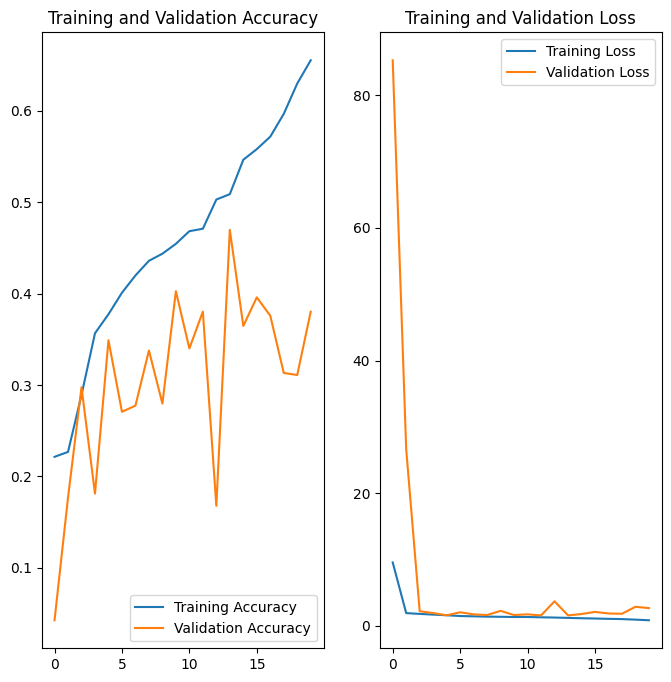

In [25]:
acc = history_augmented.history['accuracy']
val_acc = history_augmented.history['val_accuracy']

loss = history_augmented.history['loss']
val_loss = history_augmented.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

It can be seen that the validation accuracy has increased and thus the augmentation process has helped.